In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from toolz import partial
from pathlib import Path
from aging.plotting import format_plots, figure, legend, add_identity
import colorcet as cc
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from scipy.stats import expon

In [2]:
def reindex_c(df1, df2):
    return df1.reindex(columns=df2.columns).fillna(0)

In [3]:
dotted_identity = partial(add_identity, linestyle='--', color='k')

In [4]:
format_plots()

In [5]:
version = 8
folder = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}")

In [6]:
usages = pd.read_parquet(folder / "ontogeny_males_clean_v2.parquet").fillna(0).astype('float32')
long_usages = pd.read_parquet(folder / "longtogeny_males_clean_v1.parquet").fillna(0).astype('float32')
long_usages = long_usages[long_usages.index.get_level_values('age') < 600]

In [7]:
keep_syll = usages.quantile(0.9) > 0.01
keep_syll = keep_syll[keep_syll].index

In [8]:
from sklearn.feature_selection import mutual_info_regression

In [9]:
age = usages.index.get_level_values('age')
long_age = long_usages.index.get_level_values('age') / 7

In [10]:
mi = mutual_info_regression(usages[keep_syll], age, discrete_features=False)

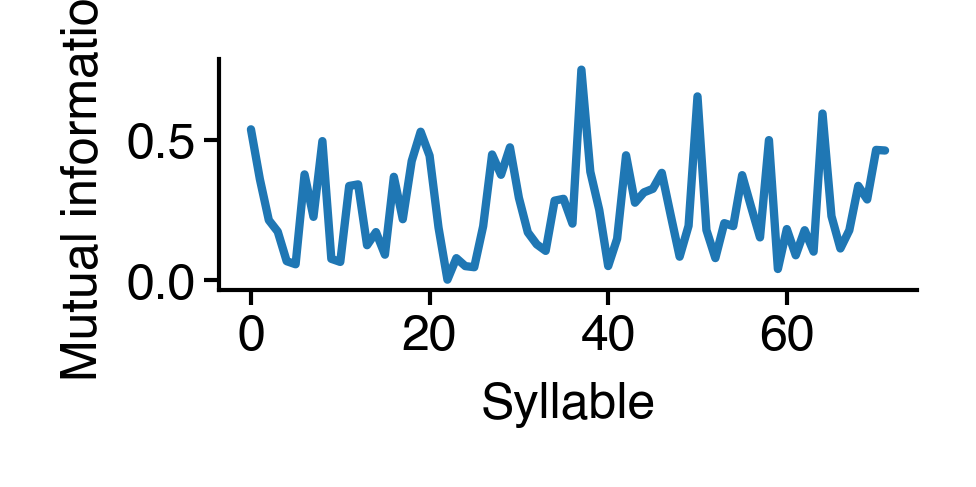

In [11]:
figure(1.5, 0.5)
plt.plot(mi)
plt.ylabel("Mutual information")
plt.xlabel("Syllable")
sns.despine()

In [12]:
# select best syllables based on mutual information
sorted_syllables = keep_syll[np.argsort(mi)[::-1]]

In [13]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())

In [14]:
r2s = {}
long_r2s = {}
for n in tqdm(range(1, len(sorted_syllables))):
    preds = cross_val_predict(
        pipeline, usages[sorted_syllables[:n]], age, cv=LeaveOneGroupOut(), groups=age
    )
    r2s[n] = r2_score(age, preds)
    mdl = pipeline.fit(usages[sorted_syllables[:n]], age)
    long_r2s[n] = r2_score(
        long_age, mdl.predict(reindex_c(long_usages, usages)[sorted_syllables[:n]])
    )

  0%|          | 0/71 [00:00<?, ?it/s]

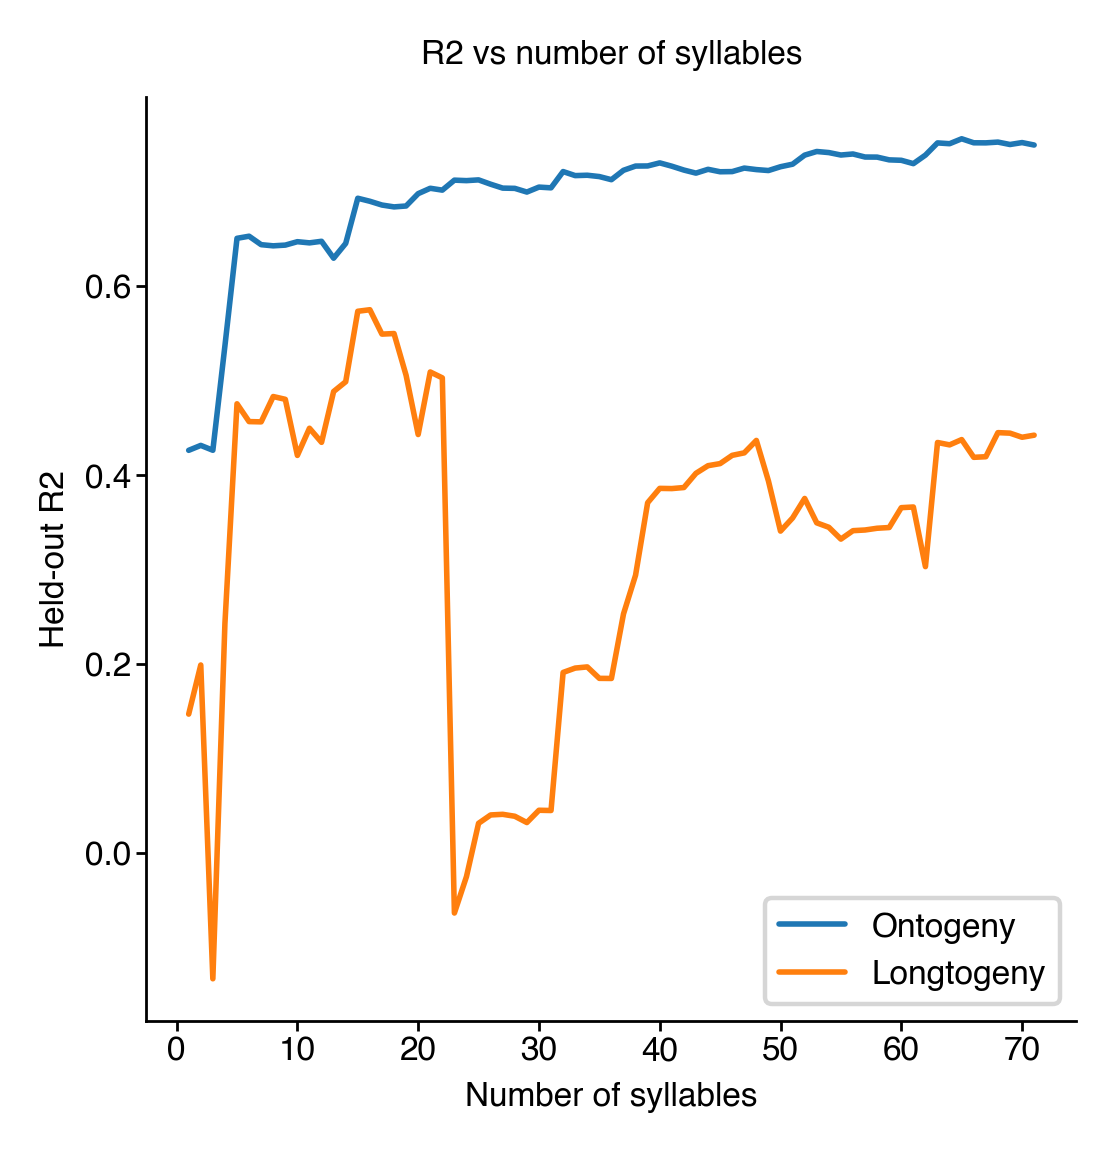

In [15]:
ax = pd.Series(r2s, name="Ontogeny").plot()
ax = pd.Series(long_r2s, name="Longtogeny").plot()
ax.set(
    xlabel="Number of syllables",
    ylabel="Held-out R2",
    title="R2 vs number of syllables",
)
plt.legend()
sns.despine()

In [86]:
class_probs = expon.pdf(np.arange(0, len(keep_syll) - 3), scale=13)
class_probs = class_probs / class_probs.sum()
mi2 = mi + 0.05
syll_probs = mi2 / mi2.sum()

In [87]:
def sample_generator(class_probs, syll_probs, n_samples=1_000, seed=0):
    rng = np.random.RandomState(seed)
    n_classes = rng.choice(range(3, len(syll_probs)), size=n_samples, p=class_probs)
    for n in n_classes:
        yield rng.choice(keep_syll, size=n, p=syll_probs).astype(int)

In [100]:
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())

In [101]:
n_samples = 20_000
pbar = tqdm(sample_generator(class_probs, syll_probs, n_samples=n_samples, seed=1), total=n_samples)

bf_r2s = {}
bf_long_r2s = {}

best_r2 = -np.inf
best_long_r2 = -np.inf
best_syll = tuple()
best_long_syll = tuple()

for syll_group in map(tuple, pbar):
    preds = cross_val_predict(
        pipeline,
        usages[list(syll_group)],
        age,
        cv=LeaveOneGroupOut(),
        groups=age,
        n_jobs=-1,
    )
    bf_r2s[syll_group] = r2_score(age, preds)
    mdl = pipeline.fit(usages[list(syll_group)], age)
    bf_long_r2s[syll_group] = r2_score(
        long_age, mdl.predict(reindex_c(long_usages, usages)[list(syll_group)])
    )
    if bf_r2s[syll_group] > best_r2:
        best_r2 = bf_r2s[syll_group]
        best_syll = syll_group
    if bf_long_r2s[syll_group] > best_long_r2:
        best_long_r2 = bf_long_r2s[syll_group]
        best_long_syll = syll_group
    pbar.set_description(
        f"R2: {best_r2:.3f} {len(best_syll)}, long R2:" + 
        f" {best_long_r2:.3f} {len(best_long_syll)}"
    )

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

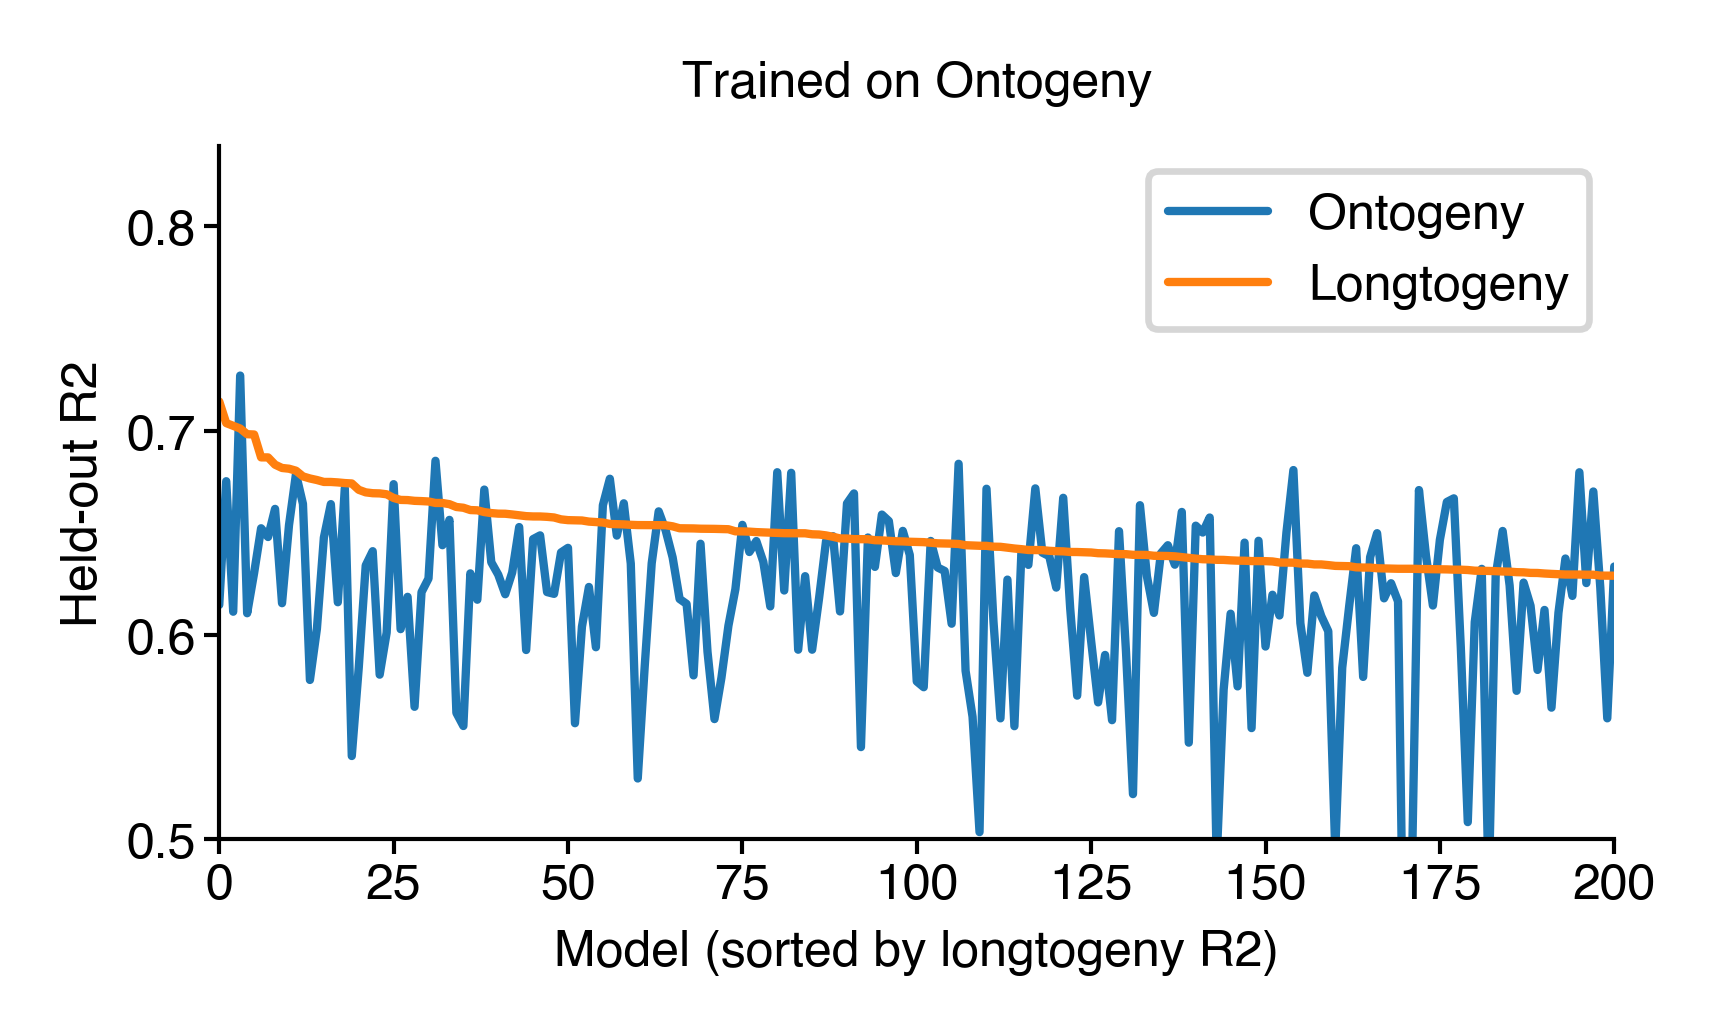

In [102]:
sorted_dict = {k: v for k, v in sorted(bf_long_r2s.items(), key=lambda item: item[1], reverse=True)}
figure(3, 1.5)
plt.plot([bf_r2s[k] for k in sorted_dict.keys()], label="Ontogeny")
plt.plot(sorted_dict.values(), label="Longtogeny")
plt.xlim(0, 200)
plt.ylim(0.5, None)
plt.xlabel("Model (sorted by longtogeny R2)")
plt.ylabel("Held-out R2")
plt.title("Trained on Ontogeny")
plt.legend()
sns.despine()

In [103]:
from toolz import take

In [104]:
inp = []
index = []
for k in map(list, take(200, filter(lambda k: bf_r2s[k] > 0.65, sorted_dict.keys()))):
    arr = np.zeros(75)
    arr[k] = 1
    inp.append(arr)
    # index.append(bf_r2s[tuple(k)])
    index.append(bf_long_r2s[tuple(k)])
df = pd.DataFrame(inp, index=index)

<Axes: >

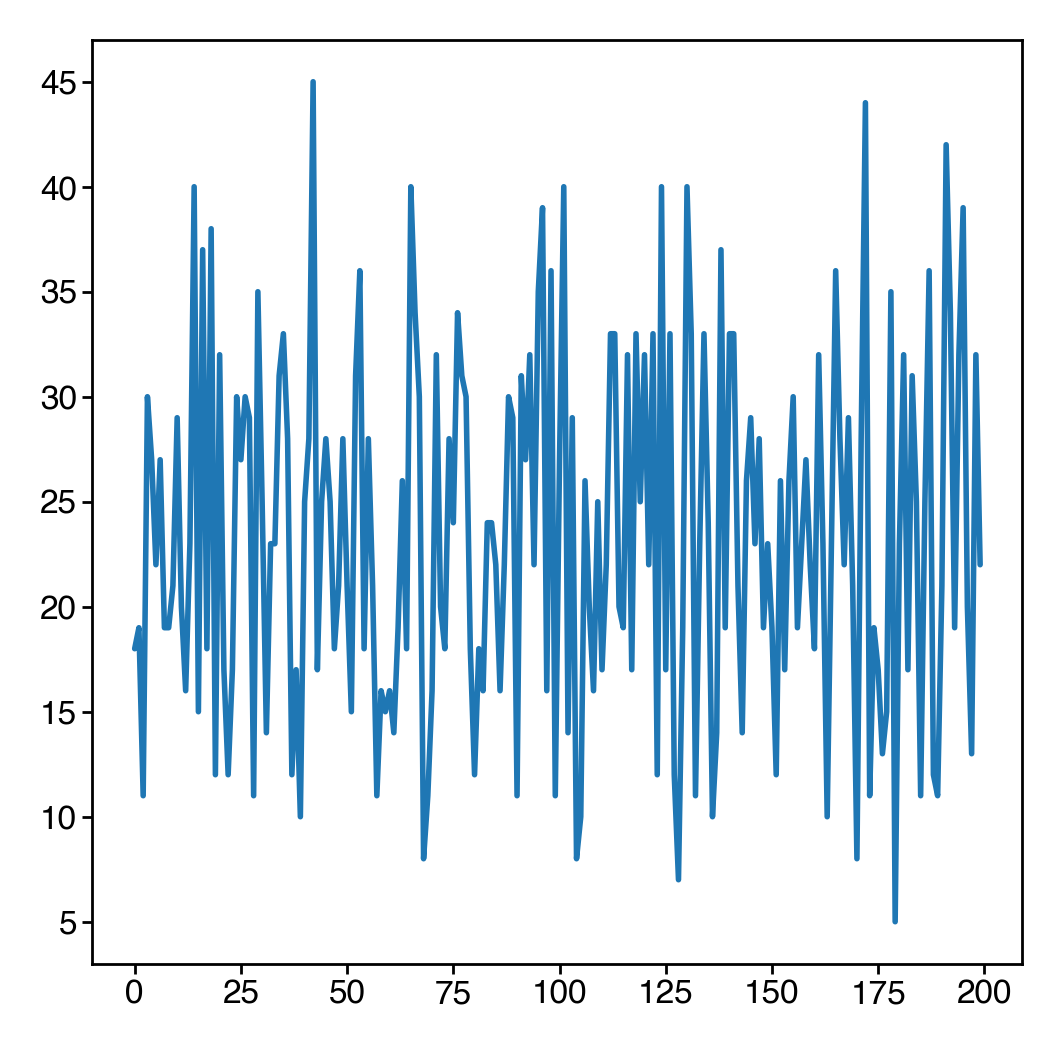

In [105]:
df.sort_index(ascending=False).reset_index(drop=True).sum(axis=1).plot()

[Text(0.5, 0, 'Syllable ID'),
 Text(0, 0.5, 'Model num'),
 Text(0.5, 1.0, 'Is feature?')]

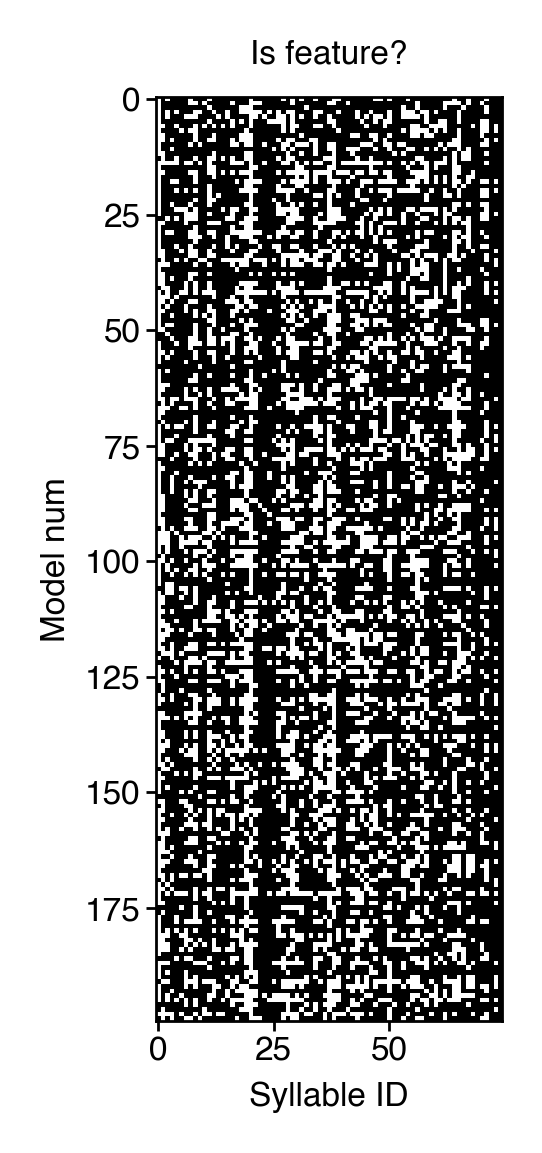

In [106]:
plt.imshow(df.sort_index(ascending=False), interpolation='none', cmap='bone')
ax = plt.gca()
ax.set(xlabel="Syllable ID", ylabel="Model num", title="Is feature?")

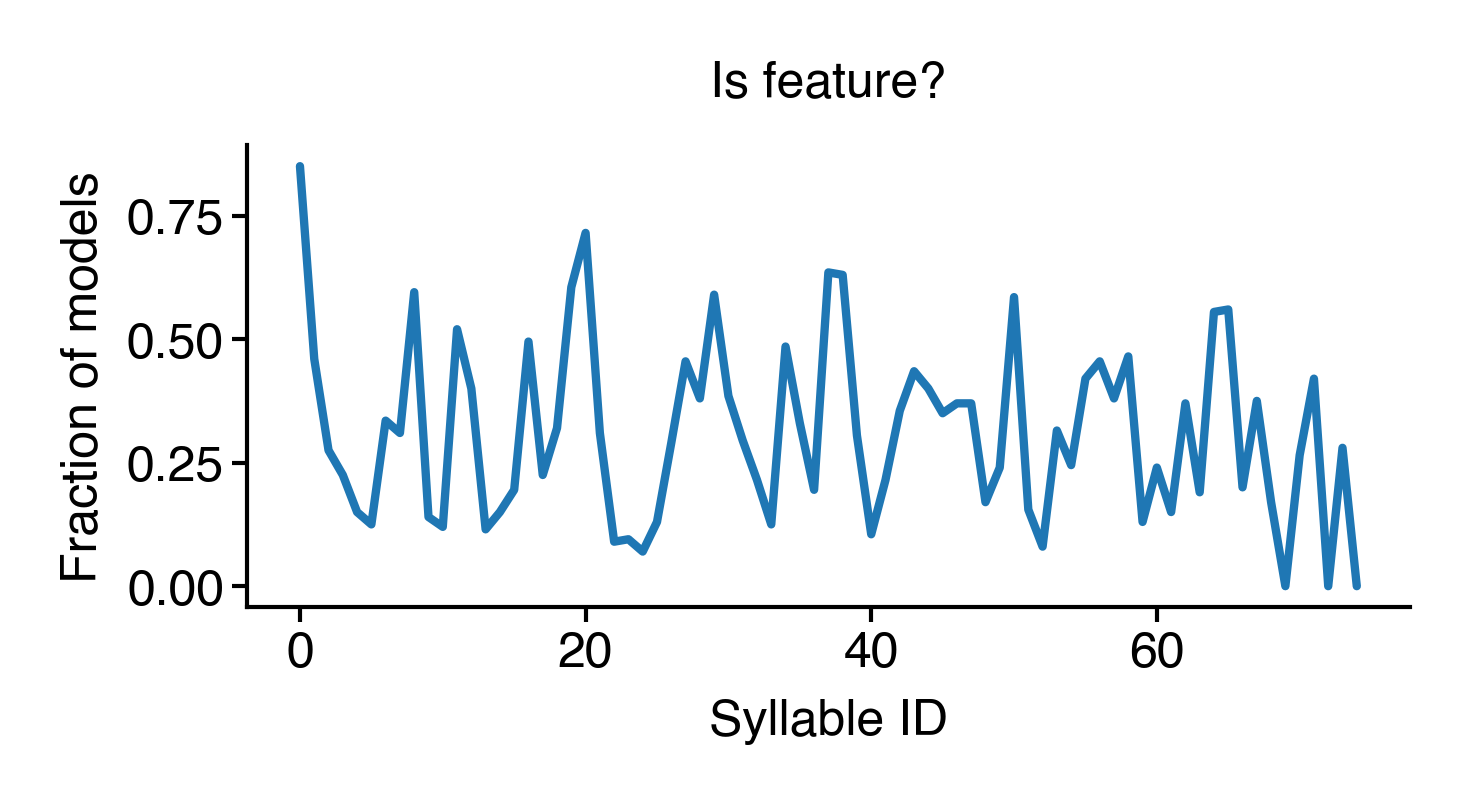

In [107]:
figure(2.5, 1)
ax = df.mean().plot()
ax.set(ylabel="Fraction of models", xlabel="Syllable ID", title="Is feature?")
sns.despine()

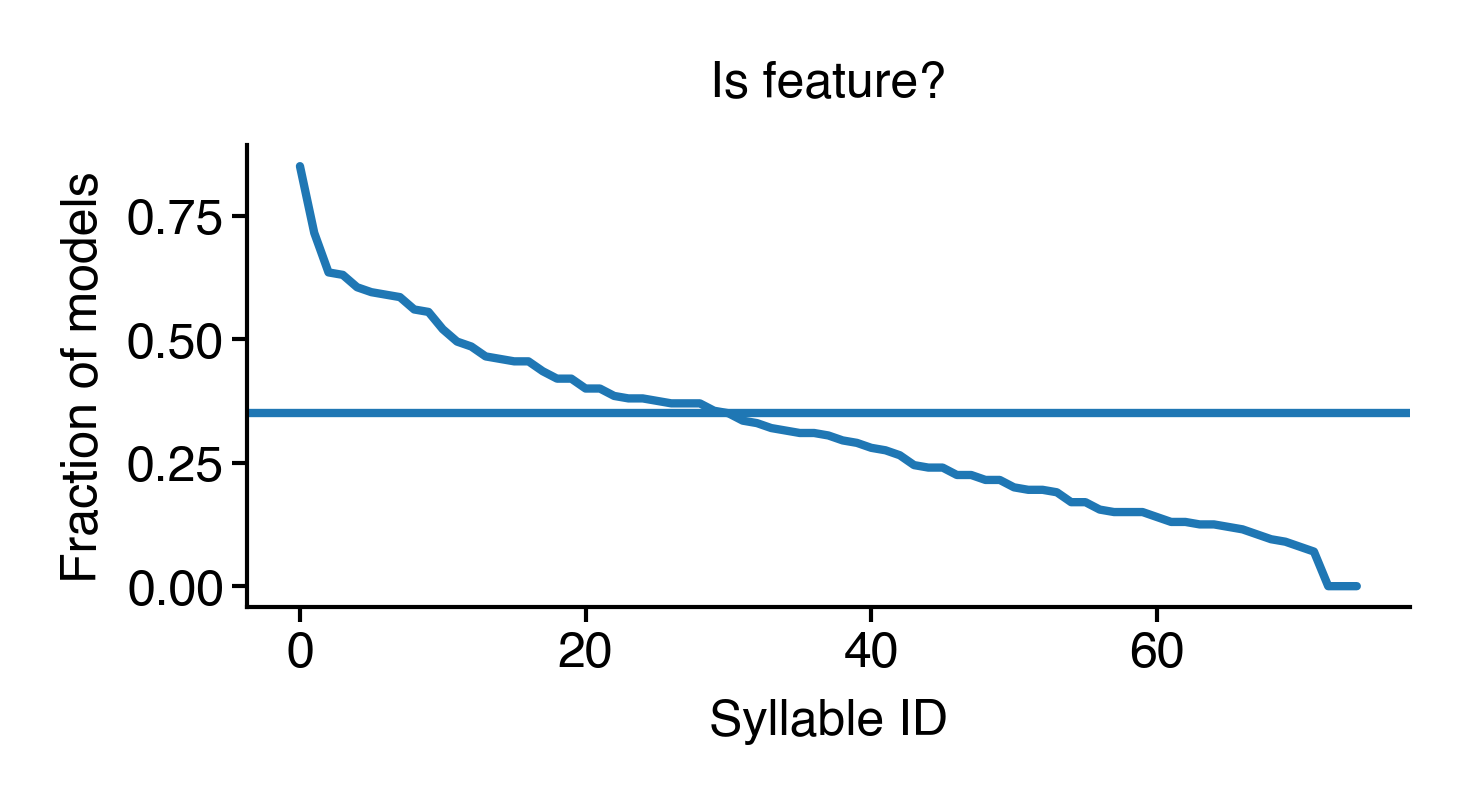

In [108]:
figure(2.5, 1)
ax = df.mean().sort_values(ascending=False).reset_index(drop=True).plot()
ax.axhline(0.35)
ax.set(ylabel="Fraction of models", xlabel="Syllable ID", title="Is feature?")
sns.despine()

In [109]:
frac = df.mean() > 0.4

In [110]:
model_sylls = frac[frac].index
model_sylls

Index([0, 1, 8, 11, 16, 19, 20, 27, 29, 34, 37, 38, 43, 50, 55, 56, 58, 64, 65,
       71],
      dtype='int64')

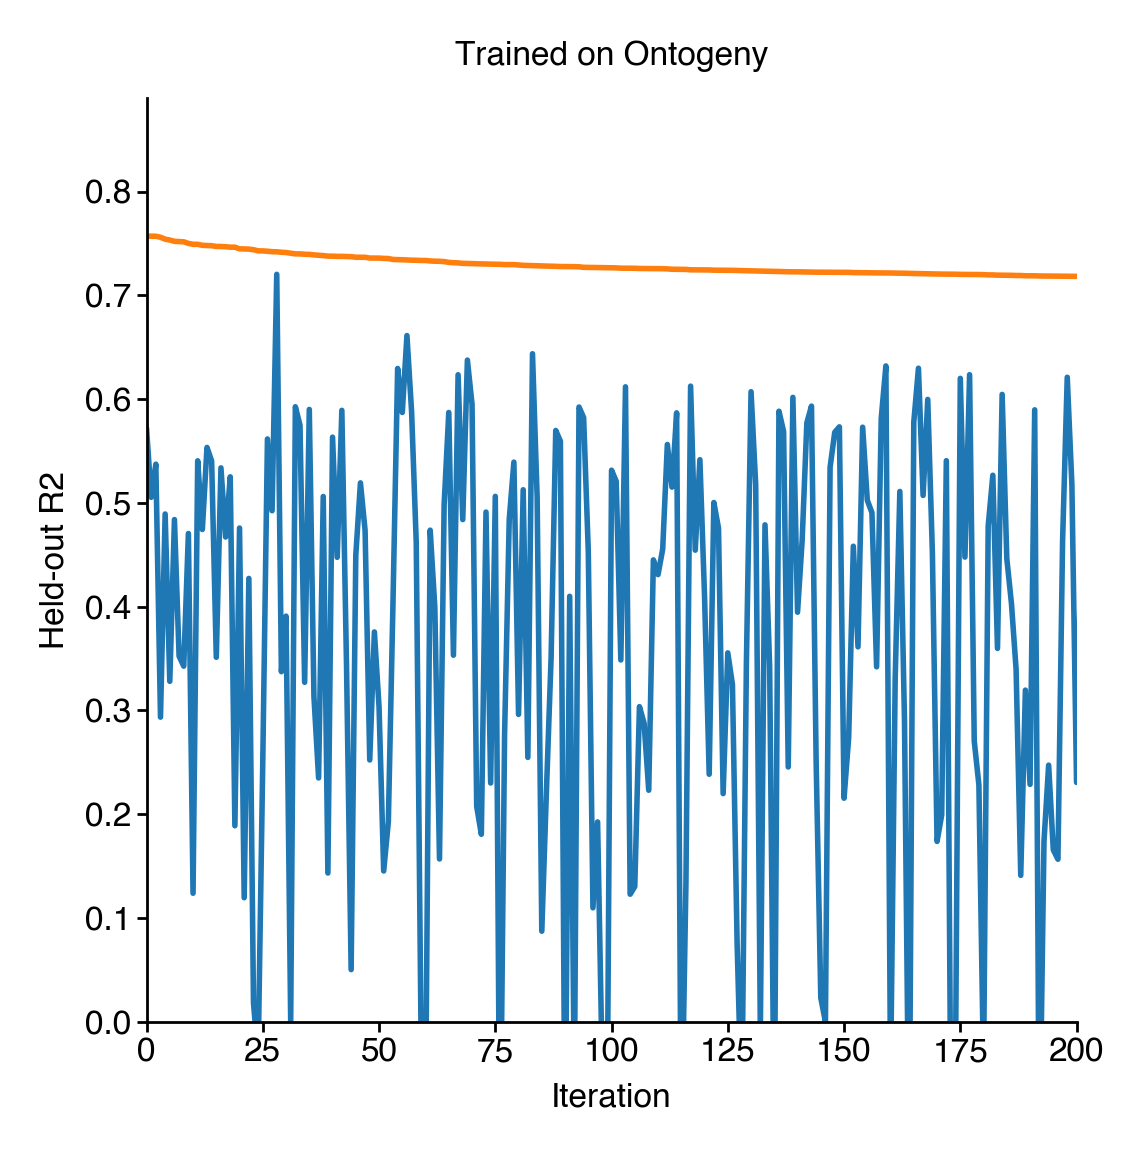

In [59]:
sorted_dict = {k: v for k, v in sorted(bf_r2s.items(), key=lambda item: item[1], reverse=True)}
plt.plot([bf_long_r2s[k] for k in sorted_dict.keys()], label="Ontogeny")
plt.plot(sorted_dict.values(), label="Ontogeny")
plt.xlim(0, 200)
plt.ylim(0, None)
plt.xlabel("Iteration")
plt.ylabel("Held-out R2")
plt.title("Trained on Ontogeny")
sns.despine()

[None]

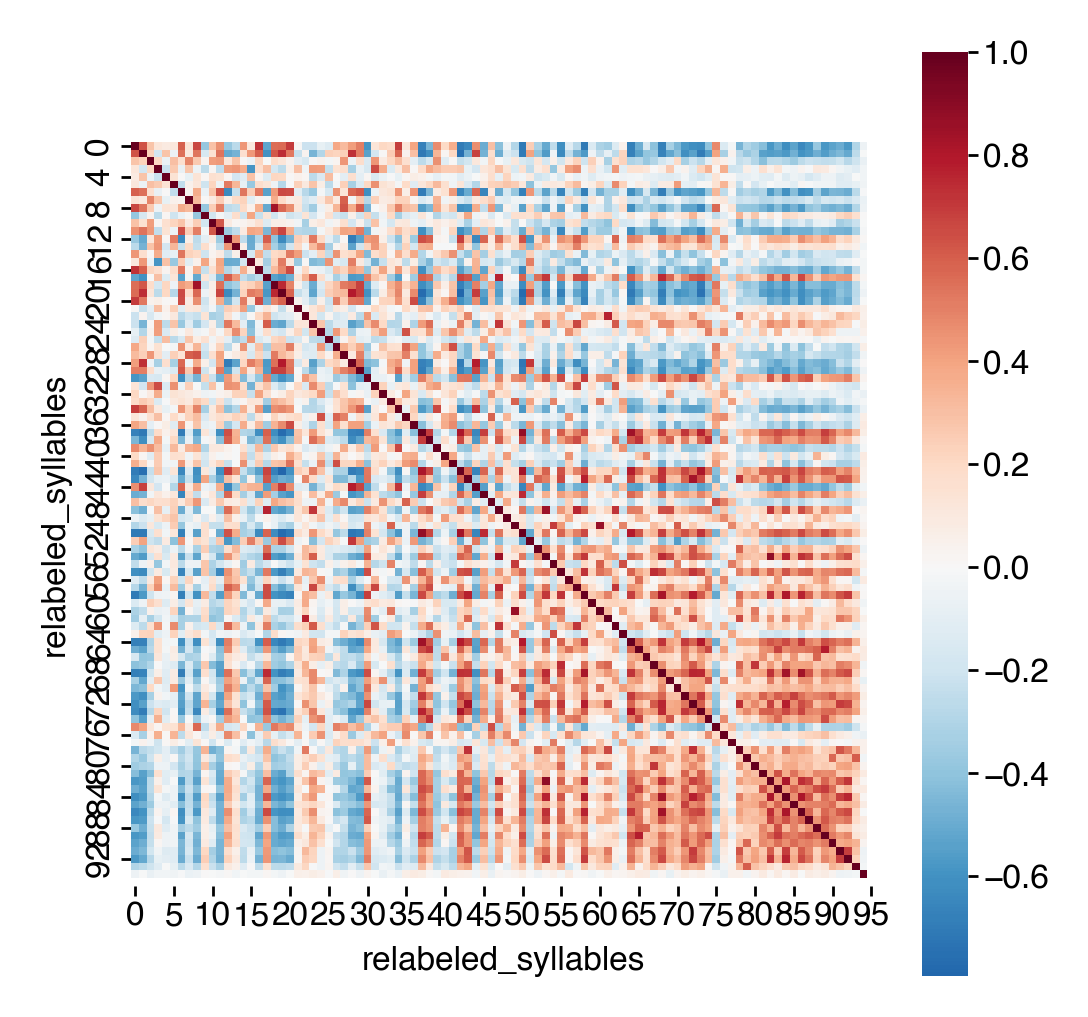

In [60]:
ax = sns.heatmap(usages.corr(method='spearman'), cmap='RdBu_r', center=0, )
ax.set(aspect='equal')

## Recursive feature elimination with cross-validation

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, ShuffleSplit

In [16]:
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("reg", LinearRegression().fit(usages, age))]
)

In [41]:
cross_val_score(pipeline, usages, age, cv=StratifiedKFold(n_splits=4), groups=age)

array([0.70777972, 0.70855367, 0.82537536, 0.75158677])

In [42]:
selector = RFECV(
    pipeline,
    cv=ShuffleSplit(n_splits=10, test_size=0.5, random_state=0),
    scoring="r2",
    n_jobs=-1,
    importance_getter="named_steps.reg.coef_",
)
selector.fit(usages[keep_syll], age)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.5, train_size=None),
      estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                ('reg', LinearRegression())]),
      importance_getter='named_steps.reg.coef_', n_jobs=-1, scoring='r2')

In [43]:
pipeline.fit(usages[keep_syll[selector.support_]], age)

Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

In [44]:
pipeline.score(long_usages[keep_syll[selector.support_]], long_age)

0.3945877961412233

In [45]:
selector.n_features_, selector.n_features_in_

(24, 72)

In [46]:
np.max(selector.cv_results_['mean_test_score'])

0.7414467692117785

In [47]:
selector.ranking_

array([ 1,  1, 42, 26,  2,  4,  1, 32,  9, 34,  7, 36, 28, 39,  1, 44,  1,
        8, 10,  1,  1, 41, 31,  1, 46,  5, 33,  1,  1,  1, 30, 40, 45, 23,
        1,  1,  1,  1, 29, 27, 14,  1, 12, 19,  1,  1, 16, 20, 15, 22, 17,
       18,  1, 21, 47, 49,  1,  1,  1, 43, 25,  1, 11,  6,  3, 38, 35, 37,
        1, 24, 48, 13])

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

In [19]:
ont_r2 = {}
long_r2 = {}
for n in range(1, 40):
    sfs = SequentialFeatureSelector(
        pipeline,
        n_features_to_select=n,
        cv=ShuffleSplit(n_splits=12, test_size=0.5, random_state=0),
        scoring="r2",
        direction="forward",
        n_jobs=-1,
    ).fit(usages[keep_syll], age)
    pred = cross_val_predict(pipeline, usages[keep_syll[sfs.get_support()]], age, cv=LeaveOneGroupOut(), groups=age)
    ont_r2[n] = r2_score(age, pred)
    r = pipeline.fit(usages[keep_syll[sfs.get_support()]], age).score(
        long_usages[keep_syll[sfs.get_support()]], long_age
    )
    long_r2[n] = r
    print(n, round(r, 3))

1 0.466
2 0.584
3 0.494
4 0.4
5 0.406
6 0.481
7 0.529
8 0.513
9 0.554
10 0.575
11 0.605
12 0.587
13 0.576
14 0.572
15 0.601
16 0.601
17 0.599
18 0.622
19 0.599
20 0.6
21 0.601
22 0.557
23 0.545
24 0.49
25 0.442
26 0.461
27 0.478
28 0.463
29 0.474
30 0.474
31 0.475
32 0.488
33 0.52
34 0.518
35 0.489
36 0.473
37 0.468
38 0.456
39 0.463


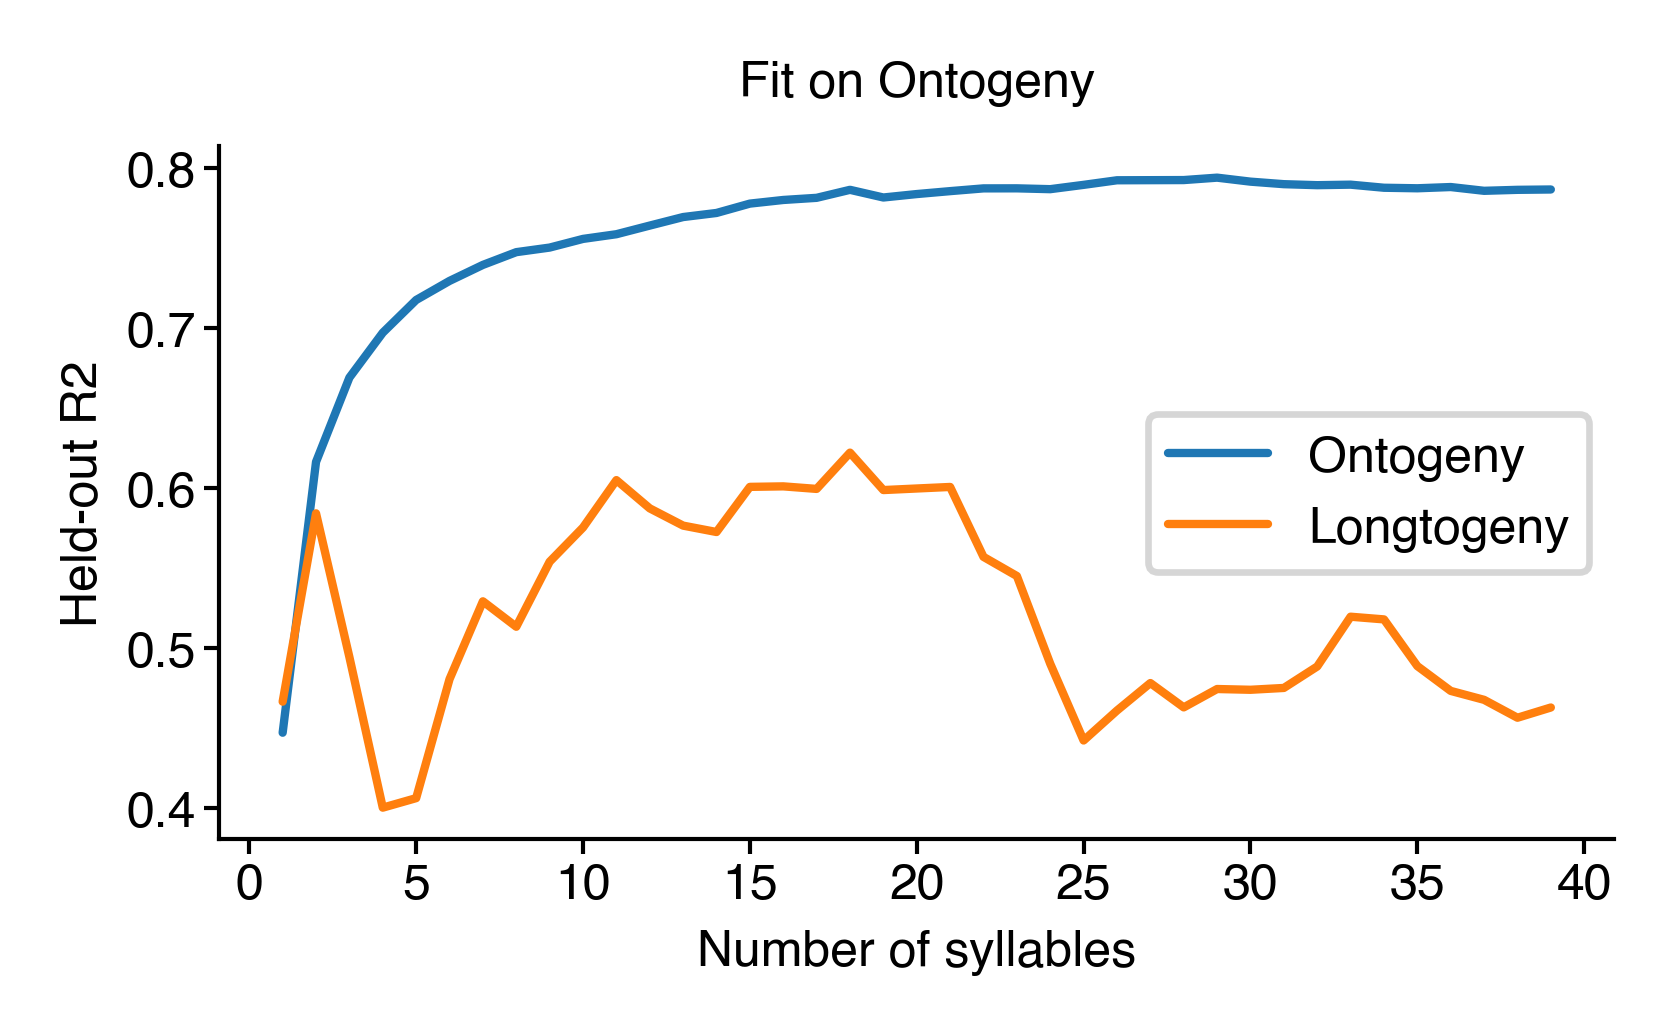

In [22]:
figure(3, 1.5)
ax = pd.Series(ont_r2, name="Ontogeny").plot()
pd.Series(long_r2, name="Longtogeny").plot()
ax.set(xlabel="Number of syllables", ylabel="Held-out R2", title="Fit on Ontogeny")
plt.legend()
sns.despine()